In [4]:
import numpy as np
import pandas as pd
import os
import argparse
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline

# We import seaborn to make nice plots
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# # We'll generate an animation with matplotlib and moviepy
# from moviepy.video.io.bindings import mplfig_to_npimage
# import moviepy.editor as mpy

from capstone_project.preprocessing import generate_dataloaders, load_data, split_data
from capstone_project.models.embedding_network import EmbeddingNetwork
from capstone_project.models.classification_network import ClassificationNetwork
from capstone_project.utils import *

from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

/home/mur214/learning_visual_embeddings/capstone_project/utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [5]:
# Globals
PROJECT_DIR = '/home/mur214/learning_visual_embeddings/'
DATA_DIR,  PLOTS_DIR, LOGGING_DIR = 'data', 'plots', 'logs'
CHECKPOINTS_DIR = 'checkpoints'
DATASET = 'mnist_test_seq.npy'
TEST_SIZE, VAL_SIZE = 0.2, 0.2

BATCH_SIZE = 64    # input batch size for training
N_EPOCHS = 100     # number of epochs to train
LR = 1e-4          # learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PASSES_FOR_GENERATION = 1   # number of passes through data for pair generation
NUM_FRAMES_IN_STACK = 2         # number of (total) frames to concatenate for each video
NUM_PAIRS_PER_EXAMPLE = 5        # number of pairs to generate for given video and time difference
TIME_BUCKETS = [[0], [1], [2], [3,4], range(5,11,1)]

RS = 20150101 # Random state

In [6]:
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']

In [7]:
# Network hyperparameters
img_dim = data.shape[-1]
in_dim, in_channels, out_dim = img_dim, NUM_FRAMES_IN_STACK, 1024
embedding_hidden_size, classification_hidden_size = 1024, 1024
num_outputs = len(TIME_BUCKETS)

In [8]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
        self.conv1 = conv3x3(in_channels, 32)
#         self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = conv3x3(32, 64)
#         self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 64)
#         self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
        output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
        output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
                            self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
                            self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [9]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

In [10]:
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(list(embedding_network.parameters()) + list(classification_network.parameters()), lr=LR)

In [11]:
embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = \
    load_checkpoint(embedding_network, classification_network, optimizer, DEVICE, 10, DATASET, NUM_FRAMES_IN_STACK, NUM_PAIRS_PER_EXAMPLE, PROJECT_DIR, CHECKPOINTS_DIR)

In [12]:
data.shape

(6000, 20, 64, 64)

In [13]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, num_frames_in_stack, transforms=None):
        self.X = X
        self.transforms = transforms
        self.num_frames_in_stack = num_frames_in_stack
        self.seq_len = X.shape[1]

    def __getitem__(self, index):
        video = self.X[index]
        stacked_frames = []
        
        for frame in range(self.num_frames_in_stack-1, self.seq_len):
            frame_numbers = np.array(range(frame-self.num_frames_in_stack+1, frame+1))
            frames = video[frame_numbers]
            if self.transforms:
                frames = self.transforms(frames)
            stacked_frames.append(frames)
            
        return torch.from_numpy(np.array(stacked_frames)) # torch.from_numpy uses same memory

    def __len__(self):
        return len(self.X)

In [14]:
embedding_dataset = EmbeddingDataset(data, NUM_FRAMES_IN_STACK)

In [15]:
dataloader = DataLoader(embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [16]:
def get_embeddings(embedding_network, dataloader, criterion, device):
    all_embeddings = np.array([])
    all_videos = np.array([])
    embedding_network.eval()
    with torch.no_grad():
        for batch_idx, all_stacked_frames in enumerate(dataloader):
            # Reshape (64,19,2,121,121) -> (19,64,2,121,121)
            all_stacked_frames = all_stacked_frames.numpy().swapaxes(0, 1)
            all_stacked_frames = torch.from_numpy(all_stacked_frames).to(DEVICE).float()
            embeddings = []
            videos = np.array([])
            for stacked_frames in all_stacked_frames:
                embedding_output = embedding_network(stacked_frames).detach().cpu().numpy()
                embeddings.append(embedding_output)
                
                frames = stacked_frames.detach().cpu().numpy().swapaxes(0, 1) # (2,64,121,121)
                last_frame = np.array([frames[-1]])
                videos = np.vstack((videos, last_frame)) if videos.size else last_frame
            embeddings = np.array(embeddings).swapaxes(0, 1)
            all_embeddings = np.vstack((all_embeddings, embeddings)) if all_embeddings.size else embeddings
            
            videos = videos.swapaxes(0, 1)
            all_videos = np.vstack((all_videos, videos)) if all_videos.size else np.array(videos)
    return all_embeddings, all_videos

In [17]:
embeddings_mnist, videos_mnist = get_embeddings(embedding_network, dataloader, criterion_test, DEVICE)

In [18]:
embeddings_mnist.shape

(6000, 19, 1024)

In [19]:
embeddings_mnist[0].shape

(19, 1024)

In [20]:
embeddings_mnist[0][0].shape

(1024,)

In [21]:
embeddings_mnist.reshape(-1, embedding_hidden_size).shape

(114000, 1024)

In [25]:
tsne_proj_mnist = TSNE(n_components=2, n_iter=1000, random_state=RS, n_jobs=4).fit_transform(embeddings_mnist.reshape(-1, embedding_hidden_size))

In [23]:
videos_mnist.shape

(6000, 19, 64, 64)

In [26]:
tsne_proj_mnist.shape

(114000, 2)

In [27]:
tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2).shape

(6000, 19, 2)

In [28]:
tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2)[0].shape

(19, 2)

In [29]:
tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2)[0]

array([[-9.55680294,  0.50602751],
       [-8.7549378 , -0.34832727],
       [-7.63014726,  0.55417207],
       [ 0.15803722, -1.03953051],
       [ 5.24327527, 10.18652095],
       [ 5.73926347, 10.01592173],
       [14.50400402, 12.10042838],
       [14.10626331, 12.16352237],
       [11.17644193, 11.20738468],
       [13.22627502, 14.94286355],
       [22.95391629,  4.67117643],
       [13.22936315,  6.19142292],
       [ 7.43401514,  1.10053702],
       [15.90593208, -0.45122929],
       [16.54944338, -0.47331994],
       [16.76032979,  0.17459383],
       [ 8.75312465,  5.20190075],
       [ 9.26708192, 21.36766135],
       [ 9.33750542, 21.15658467]])

In [30]:
tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2)[0][:,0]

array([-9.55680294, -8.7549378 , -7.63014726,  0.15803722,  5.24327527,
        5.73926347, 14.50400402, 14.10626331, 11.17644193, 13.22627502,
       22.95391629, 13.22936315,  7.43401514, 15.90593208, 16.54944338,
       16.76032979,  8.75312465,  9.26708192,  9.33750542])

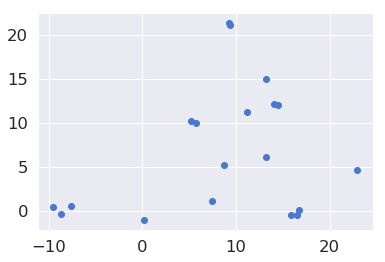

In [31]:
plt.scatter(tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2)[0][:,0], tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2)[0][:,1])

In [32]:
def plot(embeddings, kind='line', legend=True):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i, embedding in enumerate(embeddings):
        if kind == 'line':
            plt.plot(embedding[:,0], embedding[:,1], lw=2, label=i)
        elif kind == 'scatter':
            plt.scatter(embedding[:,0], embedding[:,1], lw=2, label=i)
            
    if legend:
        plt.legend()
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, ax

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efee8d3f6d8>)

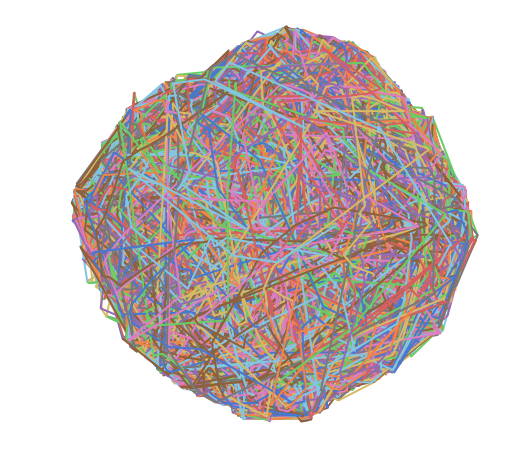

In [56]:
plot(tsne_proj_mnist.reshape(-1, embeddings_mnist.shape[1], 2), kind='line', legend=False)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efee90ff5c0>)

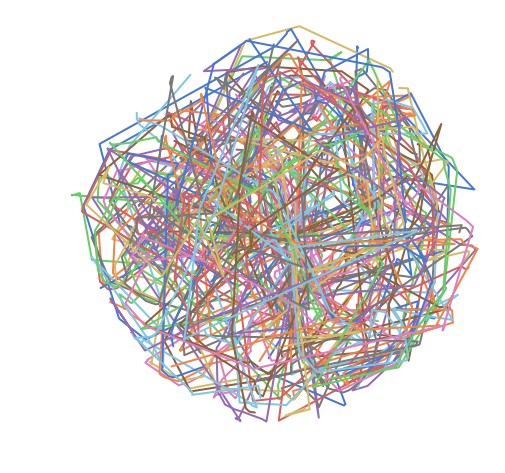

In [51]:
plot(tsne_proj_mnist[:19*100].reshape(-1, embeddings_mnist.shape[1], 2), kind='line', legend=False)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efed88b1ba8>)

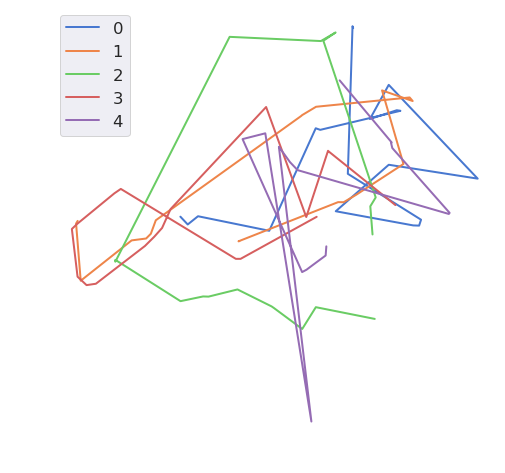

In [67]:
plot(tsne_proj_mnist[:19*5].reshape(-1, embeddings_mnist.shape[1], 2), kind='line')

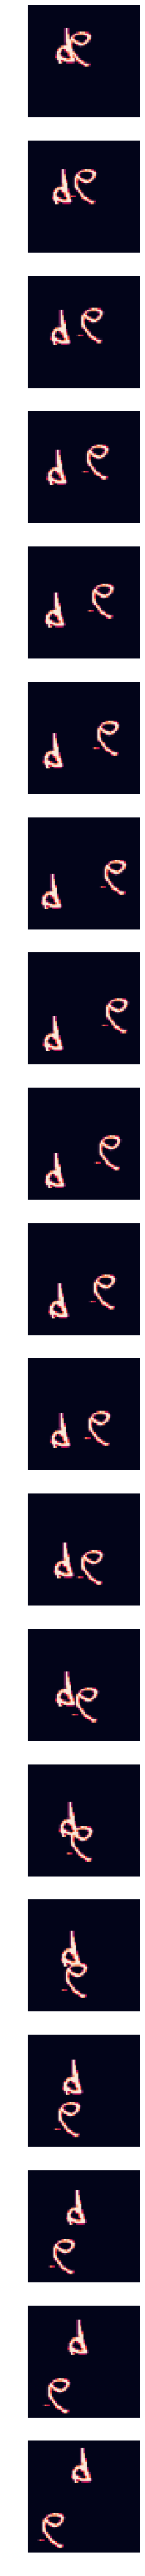

In [66]:
i = 1
fig = plt.figure(figsize=(64,64))
for image in videos_mnist[0]:
    fig.add_subplot(19, 1, i)
    plt.imshow(image)
    plt.xlim(0, 64)
    plt.ylim(0, 64)
    plt.axis('off')
    i += 1
plt.show()

In [34]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
#         self.conv1 = conv3x3(in_channels, 32)
        self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = conv3x3(32, 64)
        self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = conv3x3(64, 64)
        self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
#                             self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
#                             self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [35]:
DATASET = 'moving_bars_20_121.npy'
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']

In [36]:
# Network hyperparameters
img_dim = data.shape[-1]
in_dim = img_dim

In [37]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

In [38]:
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(list(embedding_network.parameters()) + list(classification_network.parameters()), lr=LR)

In [39]:
embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = \
    load_checkpoint(embedding_network, classification_network, optimizer, DEVICE, 200, DATASET, NUM_FRAMES_IN_STACK, NUM_PAIRS_PER_EXAMPLE, PROJECT_DIR, CHECKPOINTS_DIR)

In [40]:
embedding_dataset = EmbeddingDataset(data, NUM_FRAMES_IN_STACK)

In [41]:
dataloader = DataLoader(embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [42]:
embeddings_bars, videos_bars = get_embeddings(embedding_network, dataloader, criterion_test, DEVICE)

In [43]:
tsne_proj_bars = TSNE(n_components=2, n_iter=1000, random_state=RS, n_jobs=4).fit_transform(embeddings_bars.reshape(-1, embedding_hidden_size))

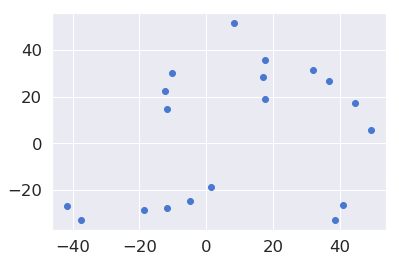

In [44]:
plt.scatter(tsne_proj_bars.reshape(-1, embeddings_bars.shape[1], 2)[0][:,0], tsne_proj_bars.reshape(-1, embeddings_bars.shape[1], 2)[0][:,1])

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efee8f3c828>)

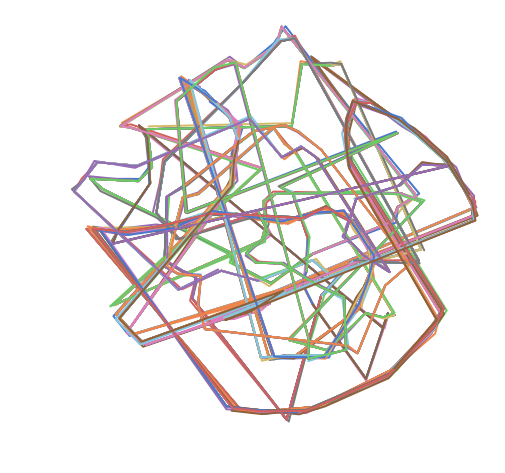

In [55]:
plot(tsne_proj_bars.reshape(-1, embeddings_bars.shape[1], 2), kind='line', legend=False)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efee92d6160>)

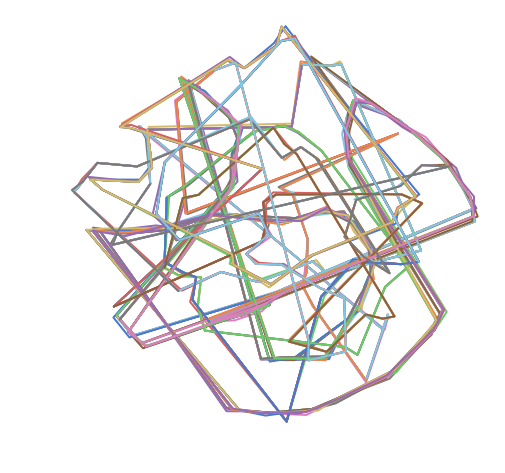

In [45]:
plot(tsne_proj_bars[:19*100].reshape(-1, embeddings_bars.shape[1], 2), kind='line', legend=False)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efed8f0ed68>)

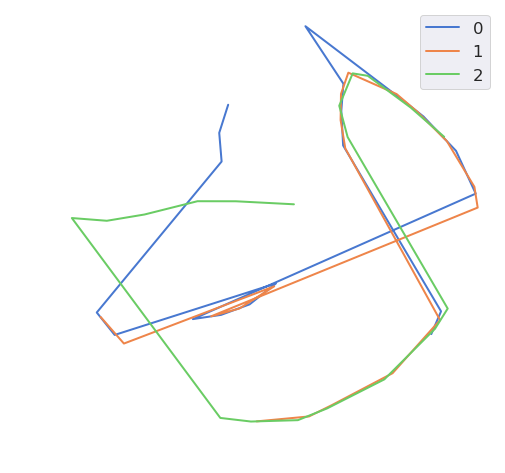

In [110]:
plot(tsne_proj_bars[:19*3].reshape(-1, embeddings_bars.shape[1], 2), kind='line')

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efed94b8128>)

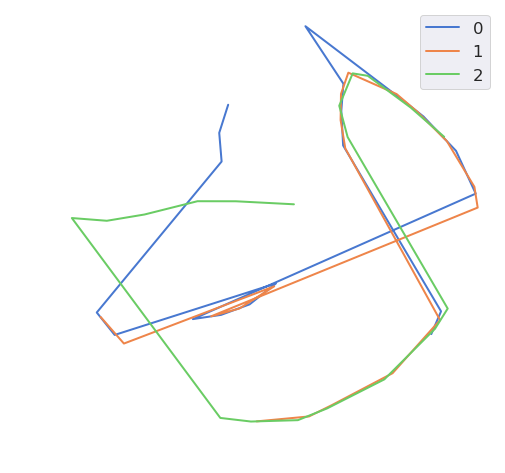

In [60]:
i, j, k = 0, 1, 2
first = tsne_proj_bars[19*i:19*(i+1)].reshape(-1, embeddings_bars.shape[1], 2)
second = tsne_proj_bars[19*j:19*(j+1)].reshape(-1, embeddings_bars.shape[1], 2)
third = tsne_proj_bars[19*k:19*(k+1)].reshape(-1, embeddings_bars.shape[1], 2)
fourth = tsne_proj_bars[19:38].reshape(-1, embeddings_bars.shape[1], 2)
plot(np.concatenate((first, second, third), axis=0), kind='line')

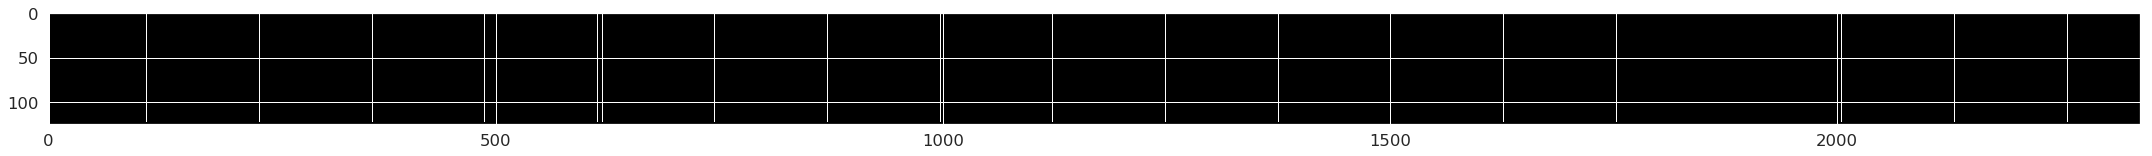

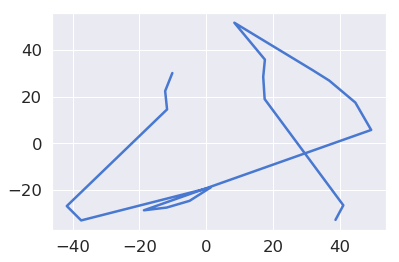

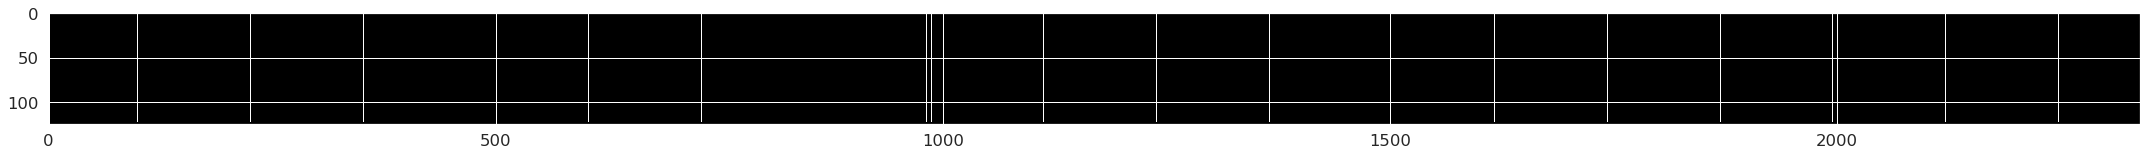

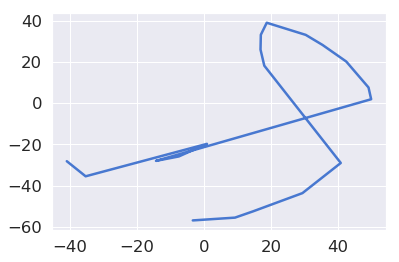

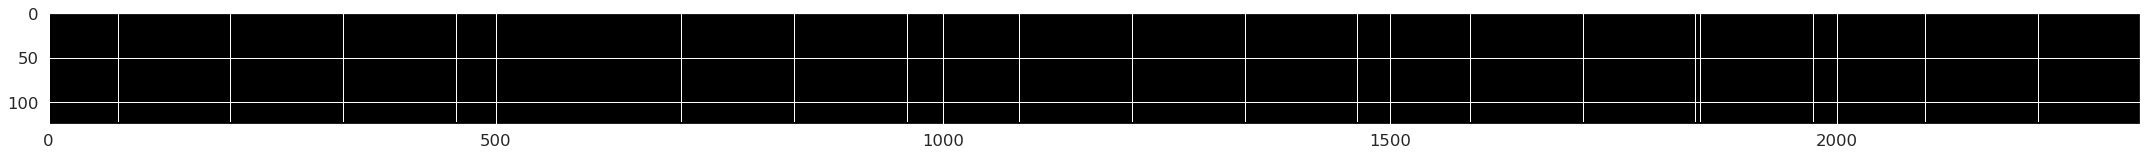

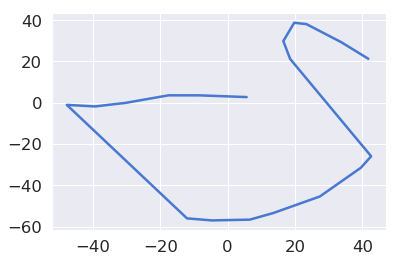

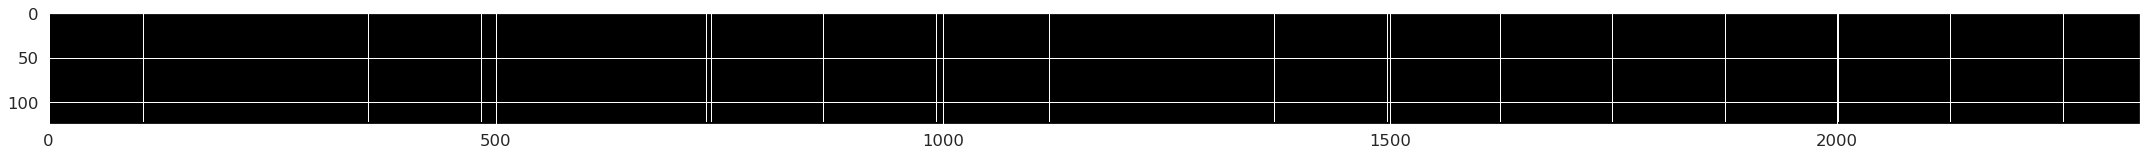

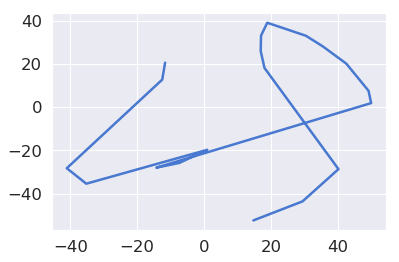

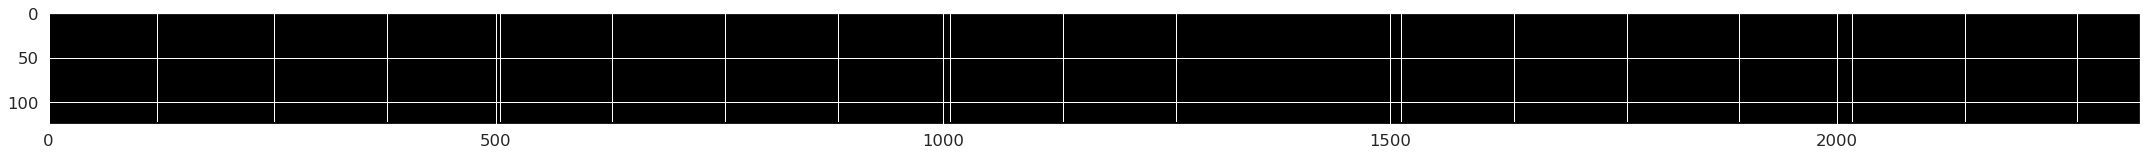

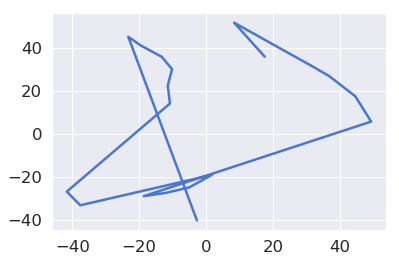

In [49]:
for i in range(5):
    images = videos_bars[i].reshape(embeddings_bars.shape[1], 1, data.shape[-1], data.shape[-1])
    images = make_grid(torch.from_numpy(images), nrow=19, normalize=True)
    np_image = images.numpy()

    fig = plt.figure(figsize=(30,10))
    plt.imshow(np.transpose(np_image, axes=(1, 2, 0)))
    plt.tight_layout()
    plt.show()

    plt.plot(tsne_proj_bars.reshape(-1, embeddings_bars.shape[1], 2)[i][:,0], tsne_proj_bars.reshape(-1, embeddings_bars.shape[1], 2)[i][:,1])
    plt.show()

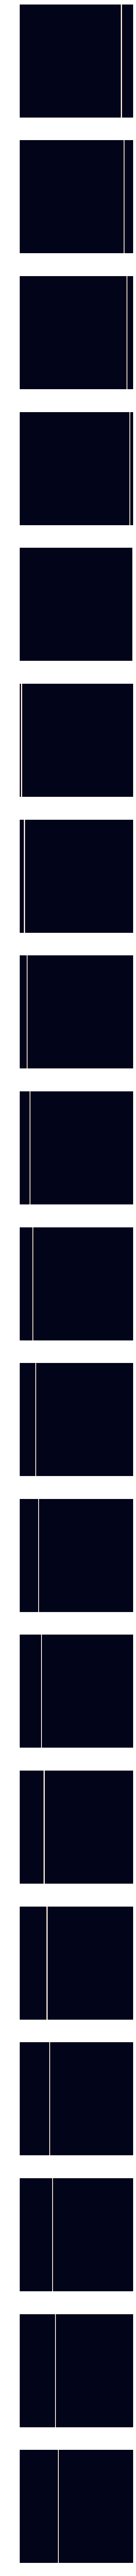

In [61]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in videos_bars[0]:
    fig.add_subplot(20, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

In [106]:
def plot2(embeddings, kind='line', legend=True):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for row, embedding in enumerate(embeddings):
        if kind == 'line':
#             plt.plot(embedding[:,0], embedding[:,1], lw=2, label=i)
            cm = plt.get_cmap('autumn')
            ax.set_prop_cycle('color', [cm(1.*i/(19-1)) for i in range(19-1)])
            for i in range(19-1):
                ax.plot(embedding[:,0][i:i+2], embedding[:,1][i:i+2], lw=2)
            ax.set_label(row)
#                 ax.plot(embedding[:,0], embedding[:,1], lw=2, label=row)
        elif kind == 'scatter':
#             plt.scatter(embedding[:,0], embedding[:,1], lw=2, label=row)
            ax.scatter(embedding[:,0][i:i+2], embedding[:,1][i:i+2], lw=2, label=row)
            
    if legend:
        plt.legend()
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, ax

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efed7935128>)

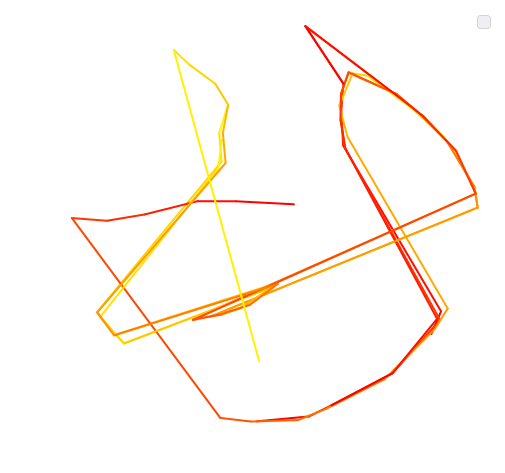

In [107]:
plot2(tsne_proj_bars[:19*5].reshape(-1, embeddings_bars.shape[1], 2), kind='line')